# Fairness Benchmark

This notebook plots the suboptimality performance of various optimization algorithms against demographic/statistical parity on the Diabetes 130-Hospitals (`diabetes`) and Adult Census (`acsincome`) benchmarks.

In [10]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from src.utils.io import get_path, var_to_str, load_results
from src.utils.data import load_dataset

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio
from tqdm import tqdm

In [11]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 32
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [12]:
l2_reg = 1.0
shift_cost = 1.0

In [13]:
# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8, 16, 1024]
batch_sizes = [32, 64, 128]

# Function to generate result directories
def generate_result_dirs(base_path, epsilon_values, batch_sizes):
    result_dirs = []
    for epsilon in epsilon_values:
        for batch_size in batch_sizes:
            result_dir = f"{base_path}\\results_{epsilon:.6f}_{batch_size}"
            result_dirs.append(result_dir)
    return result_dirs

# Base path to the experiments folder
base_path = "C:\\PrivacyInAI\\code\\prospect\\experiments"
lbfgs_path = "C:\\PrivacyInAI\\code\\prospect\\results"

# Generate the result directories
result_dirs = generate_result_dirs(base_path, epsilon_values, batch_sizes)

# Print the result directories as strings
for dir in result_dirs:
    print(f'"{dir}"')

"C:\PrivacyInAI\code\prospect\experiments\results_2.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_2.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_2.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_4.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_4.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_4.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_8.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_8.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_8.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_16.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_16.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_16.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_1024.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_1024.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_1024.000000_128"


In [14]:
plot_cfgs = [
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD",
        "color": "pink",
        "linestyle": "solid",
        "marker": "^",
    },
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },

    # {
    #     "optimizer": "saddlesaga",
    #     "label": "SaddleSAGA",
    #     "color": "goldenrod",
    #     "linestyle": "solid",
    #     "marker": "s",
    # },
    # {
    #     "optimizer": "lsvrg",
    #     "label": "LSVRG",
    #     "color": "cadetblue",
    #     "linestyle": "solid",
    #     "marker": "o",
    # },
    # {
    #     "optimizer": "prospect",
    #     "label": "Prospect (Ours)",
    #     "color": "tab:red",
    #     "linestyle": "solid",
    #     "marker": "^",
    # },
]

In [15]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    #lbfgs_path = get_path([dataset, var_to_str(model_cfg)], out_path=lbfgs_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def get_iterates(dataset, objective, optimizer, seed=1, result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results"):
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": loss,
        "n_class": None,
        "shift_cost": shift_cost
    }
    print(optimizer)
    path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
    f = os.path.join(path, f"iterates_{seed}.p")
    return [iterate.detach() for iterate in pickle.load(open(f, "rb"))]

def get_dp(column, optimizer, objective, metric="difference", result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results"):
    iterates = get_iterates(dataset, objective, optimizer, result_dir=result_dir)
    out = []
    for i, w in tqdm(enumerate(iterates)):
        print(X.shape)
        print(w.shape)
        print(w)
        y_pred = (X @ w >= 0).int()
        if metric == "difference":
            out.append(demographic_parity_difference(y, y_pred, sensitive_features=list(df[column])))
        elif metric == "ratio":
            out.append(demographic_parity_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

def get_ks_dist(y_pred, y_true):
    out = ks_2samp(y_pred, y_true, method="asymp")
    return out.statistic

def get_dist_groups(column, optimizer, objective, dataset="acsincome", method="ks", result_dir="C:\\PrivacyInAI\\code\\prospect\\results"):
    iterates = get_iterates(dataset, objective, optimizer, result_dir=result_dir)
    groups = list(df[column].unique())

    dist_groups = []

    for i, w in tqdm(enumerate(iterates)):
        y_pred = (X @ w).numpy()
        ypd = pd.Series(y_pred)
        y_groups = [(ypd.loc[df[column] == group]).to_numpy() for group in groups]
        if method == "ks":
            dist_groups.append(np.array([get_ks_dist(y_pred, y_group) for y_group in y_groups]))
        elif method == "wasserstein":
            dist_groups.append(np.array([wasserstein_dist(y_pred, y_group) for y_group in y_groups]))

    return np.array(dist_groups)

def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=1, max_epoch=32, markersize=8, out_path="../results/", result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results",lbfgs_path="C:\\PrivacyInAI\\code\\prospect\\results"):
    optimizer = plot_cfg['optimizer']
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "binary_cross_entropy" if dataset == "diabetes" else "squared_error", 
        "n_class": None,
        "shift_cost": shift_cost
    }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=result_dir)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=lbfgs_path
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        ax.plot(
            x[idx][::downsample], 
            subopt[idx][::downsample], 
            label=plot_cfg['label'], 
            color=plot_cfg['color'],
            marker=plot_cfg['marker'],
            markersize=markersize
        )

In [16]:
# import numpy as np
# import pandas as pd
# import torch
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Load diabetes dataset
# dataset = "diabetes"
# X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
# y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

# print(X.shape)
# print(y.shape)
# df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")

# print(df.gender.unique())
# print(df.race.unique())

# objectives = ["erm", "superquantile", "esrm", "extremile"]
# column = "gender"
# metric = "difference"

# sns.set_style("whitegrid")

# # Create enough subplots for both datasets
# fig, ax = plt.subplots(2, len(objectives), figsize=(20, 15))  # 2 rows for the two datasets

# obj_names = ["ERM", "CVaR", "ESRM", "EXTREMILE"]
# for j, objective in enumerate(objectives):
#     for plot_cfg in plot_cfgs:
#         optimizer = plot_cfg["optimizer"]

#         markersize = 14
#         downsample = 2

#         ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
#         print(plot_cfg)
#         plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize)
#         ax[0, j].set_yscale("log")
#         ax[0, j].set_xticklabels([])

# ax[0, 0].set_ylabel(f"Suboptimality", fontsize=32)

# # Load acsincome dataset
# dataset = "acsincome"
# X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
# y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

# print(X.shape)
# print(y.shape)

# df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")
# print(df.SEX.unique())
# print(df.RAC1P.unique())

# column = "RAC1P"

# for j, objective in enumerate(objectives):
#     for plot_cfg in plot_cfgs:
#         optimizer = plot_cfg["optimizer"]

#         markersize = 14
#         downsample = 6
#         ax[1, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)

#         plot_ax(ax[1, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize)
#         ax[1, j].set_yscale("log")
#         ax[1, j].set_xticklabels([])

# ax[1, 0].set_ylabel(f"Suboptimality", fontsize=32)

# plt.tight_layout(pad=2.0)
# handles, labels = ax[0, 0].get_legend_handles_labels()
# fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# # Save each subplot as a separate PNG file
# for i in range(2):
#     for j in range(len(objectives)):
#         extent = ax[i, j].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#         fig.savefig(f"../figures/subplot_{i}_{j}.png", bbox_inches=extent)

# plt.show()

In [17]:
plot_cfgs = [
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD",
        "color": "blue",
        "linestyle": "solid",
        "marker": "^",
    },
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },
]

NameError: name 'objectives' is not defined

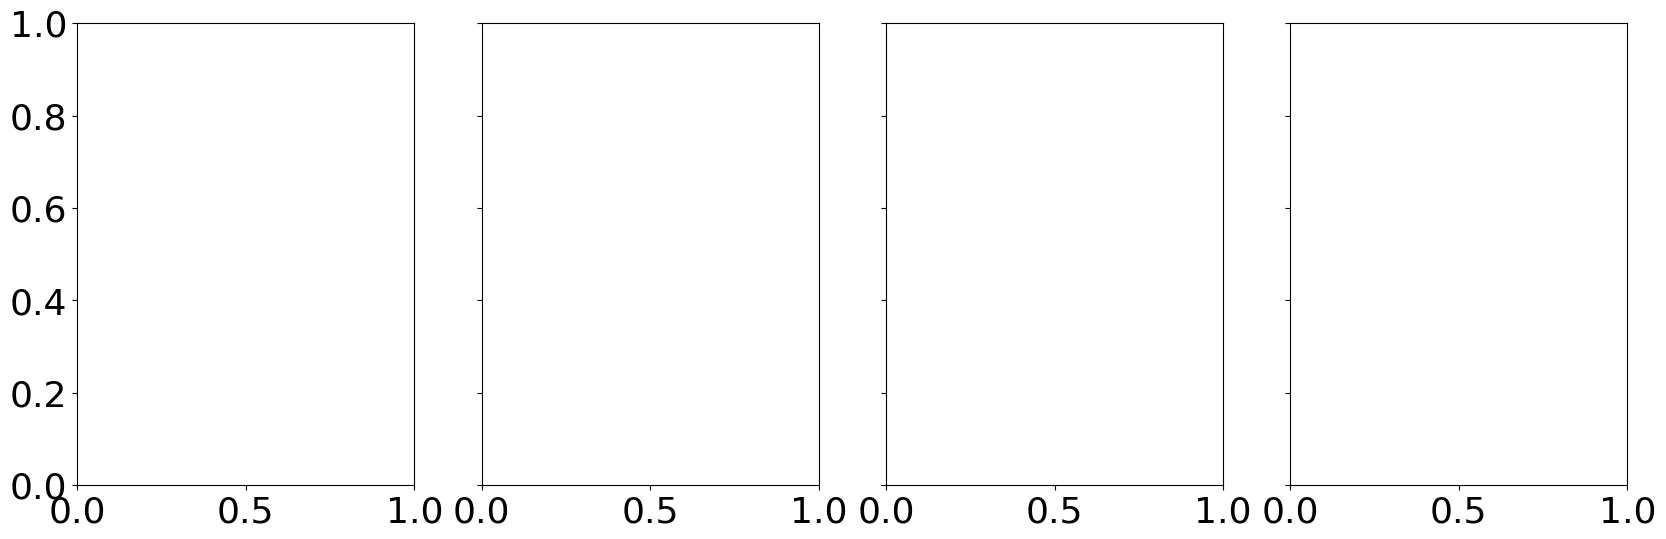

In [18]:
# List of epsilon values and batch sizes
# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8, 16]
batch_sizes = [32,128,512]
# Objective names
obj_names = ["ERM", "CVaR", "ESRM", "EXTREMILE"]

def get_color_intensity(batch_size, min_batch=32, max_batch=128):
    intensity = 0.3 + 0.7 * (batch_size - min_batch) / (max_batch - min_batch)
    return max(0, min(intensity, 1))  # Clamp intensity between 0 and 1


def get_plot_cfg(optimizer, batch_size):
    intensity = get_color_intensity(batch_size)
    if optimizer == "sgd":
        return {
            "optimizer": optimizer,
            "label": f"SGD (batch={batch_size})",
            "color": (0, 0, 0, intensity),  # Black with varying intensity
            "linestyle": "solid",
            "marker": ".",
        }
    else:  # dp_sgd
        return {
            "optimizer": optimizer,
            "label": f"DP-SGD (batch={batch_size})",
            "color": (0, 0, 1, intensity),  # Blue with varying intensity
            "linestyle": "solid",
            "marker": "^",
        }

# Create separate plots for each epsilon
for epsilon in epsilon_values:
    # Set up a 1x4 grid of subplots for the 4 objectives
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
    
    dataset = "acsincome"
    for batch_size in batch_sizes:
        for objective_idx, objective in enumerate(objectives):
            ax = axes[objective_idx]  # Select the subplot for the current objective
            
            # Create plot configurations for the current batch size
            plot_cfgs = [
                get_plot_cfg("sgd", batch_size),
                get_plot_cfg("dp_sgd", batch_size)
            ]
            
            for plot_cfg in plot_cfgs:
                optimizer = plot_cfg["optimizer"]
                result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
                lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
                
                plot_ax(ax, [1], objective, plot_cfg, dataset, 
                        max_epoch=64, downsample=6, markersize=14, 
                        result_dir=result_dir, lbfgs_path=lbfgs_path)
            
            # Set title and label for each subplot using obj_names
            ax.set_title(f'{obj_names[objective_idx]} (ε={epsilon})', fontsize=12)
            ax.set_xlabel('Epoch')
            if objective_idx == 0:  # Only set the ylabel for the first subplot
                ax.set_ylabel('Suboptimality')
            ax.set_yscale('log')
    
    # Add legend to the first subplot only, adjust size and position
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc='upper right', fontsize=10)  # Adjusted font size and position
    
    plt.suptitle(f'Fairness Training Curves for acsincome (ε={epsilon})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.savefig(f"../figures/fairness_training_curves_acsincome_eps_{epsilon}.pdf", 
                bbox_inches="tight")
    plt.show()




torch.Size([1000, 31])
torch.Size([1000])
['Female' 'Male']
['Hispanic' 'Caucasian' 'AfricanAmerican' 'Unknown' 'Asian' 'Other']


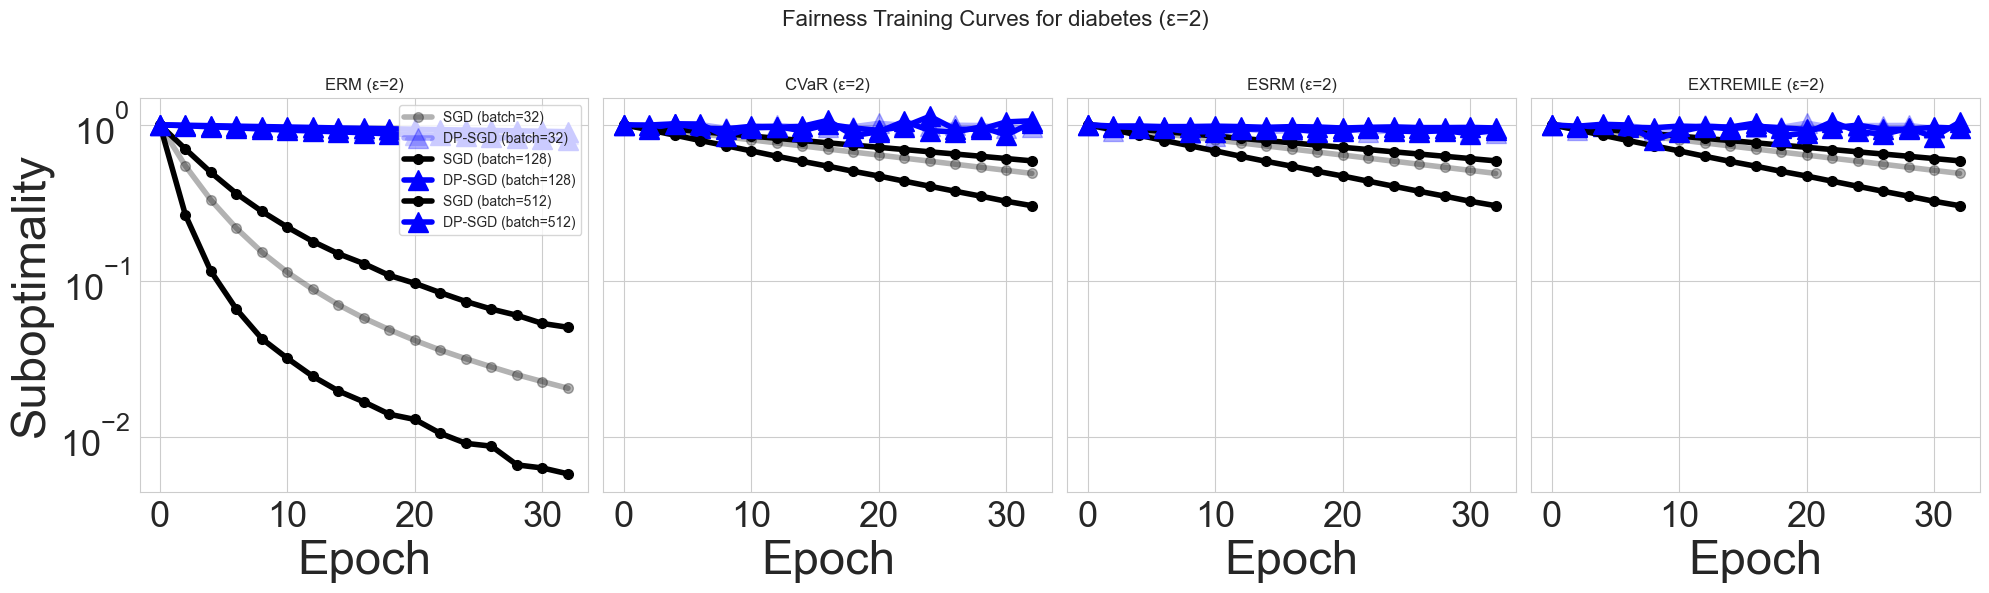

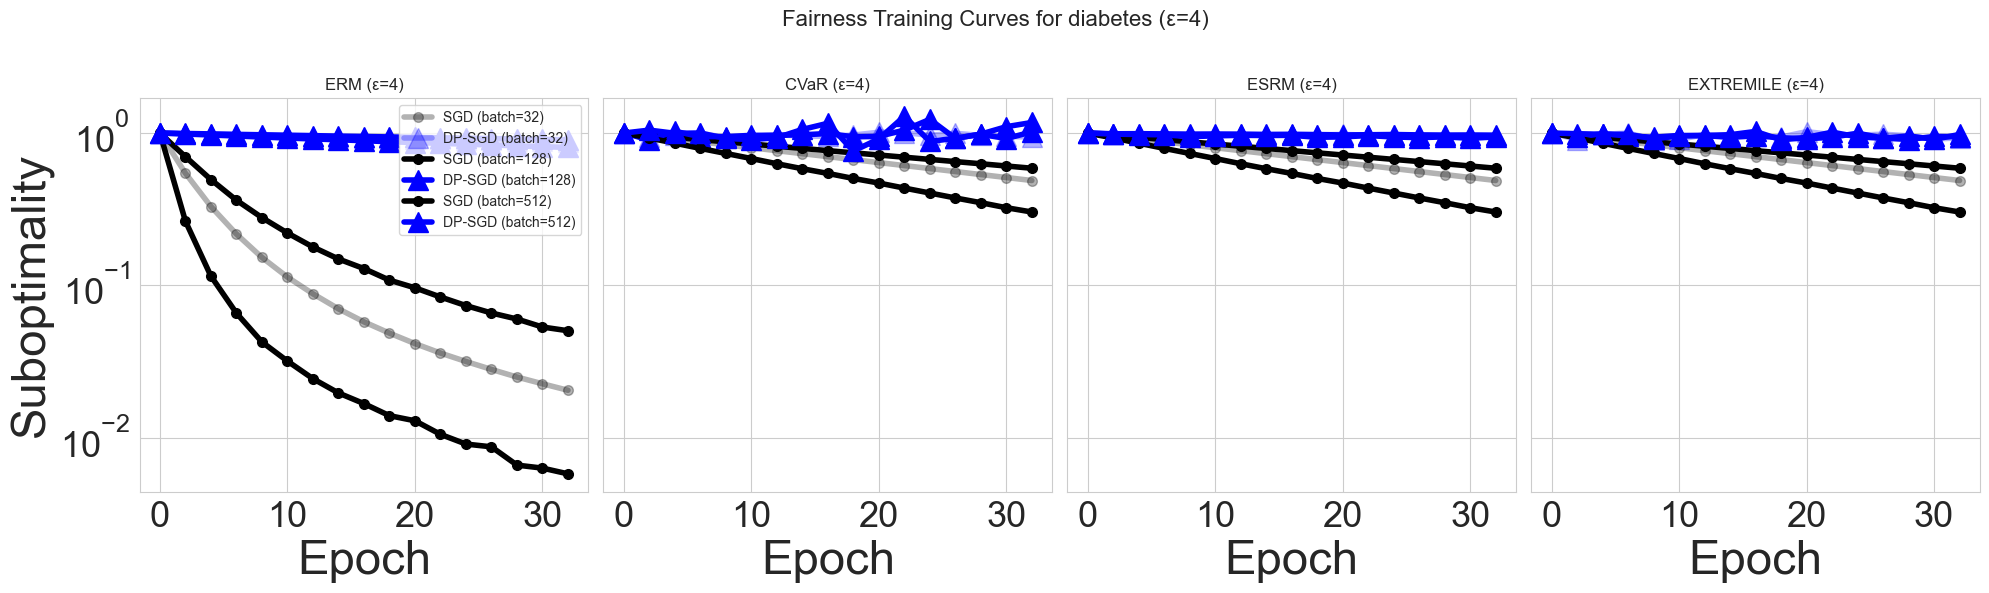

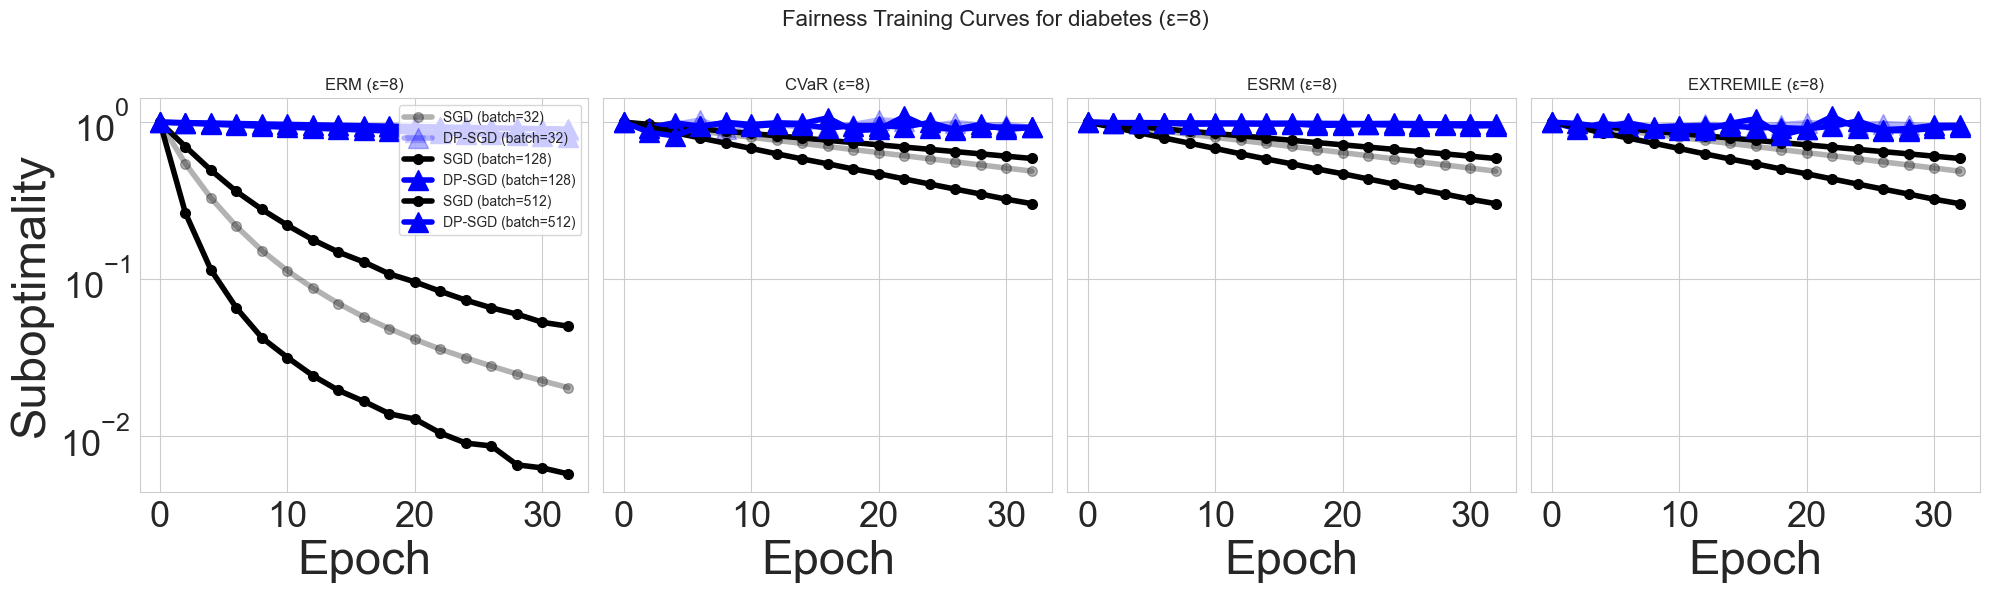

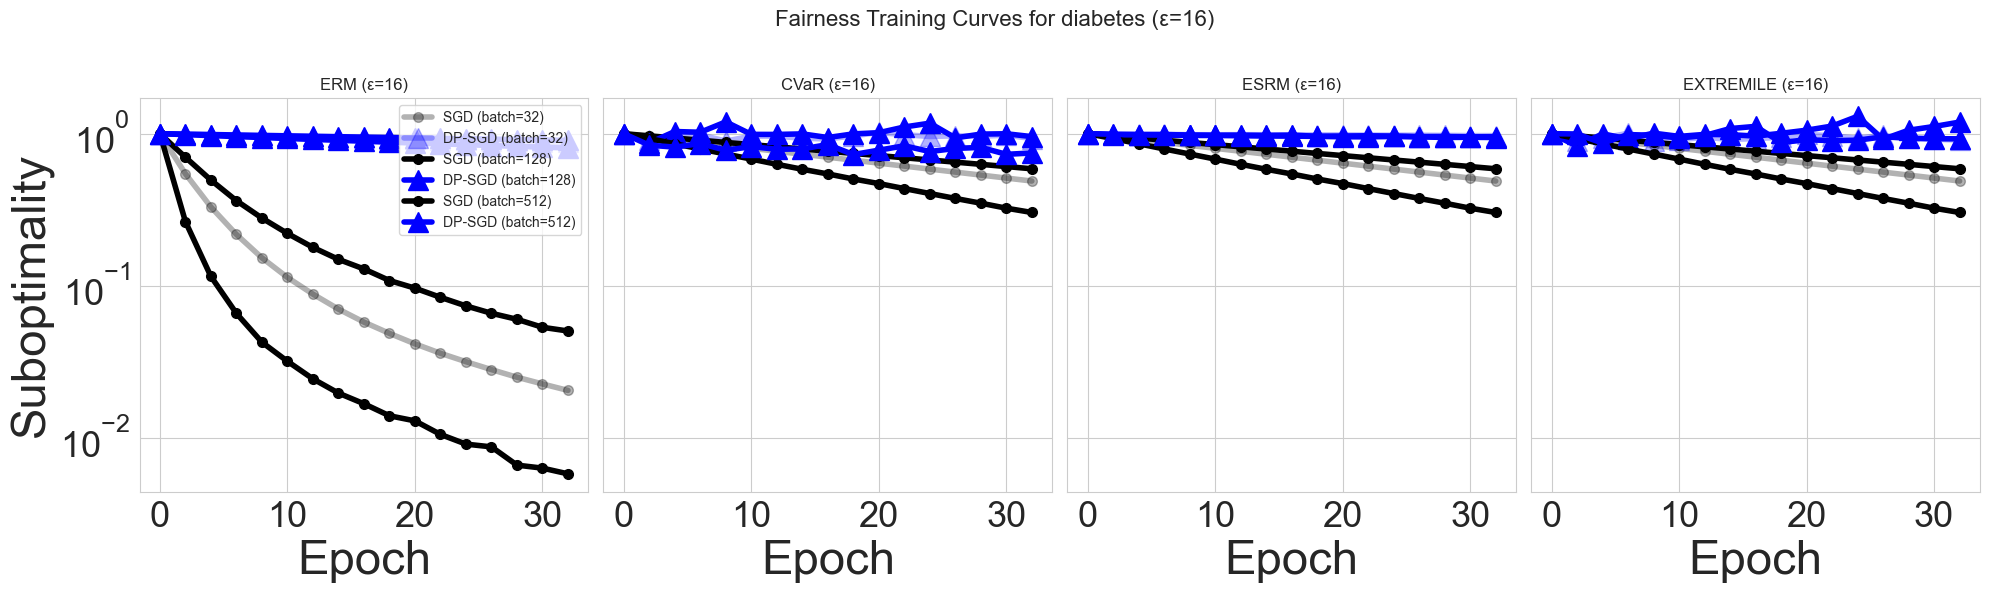

In [42]:
# Load diabetes dataset
dataset = "diabetes"
X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

print(X.shape)
print(y.shape)
df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")

print(df.gender.unique())
print(df.race.unique())

# Objective names
obj_names = ["ERM", "CVaR", "ESRM", "EXTREMILE"]
objectives = ["erm", "superquantile", "esrm", "extremile"]

# Batch sizes and color intensity scaling
epsilon_values = [2, 4, 8, 16]
batch_sizes = [32, 128, 512]

# Get color intensity with scaling between 0.3 and 1
def get_color_intensity(batch_size, min_batch=32, max_batch=128):
    intensity = 0.3 + 0.7 * (batch_size - min_batch) / (max_batch - min_batch)
    return max(0.3, min(intensity, 1))  # Clamp intensity between 0.3 and 1

# Configure plot settings for optimizers
def get_plot_cfg(optimizer, batch_size):
    intensity = get_color_intensity(batch_size)
    if optimizer == "sgd":
        return {
            "optimizer": optimizer,
            "label": f"SGD (batch={batch_size})",
            "color": (0, 0, 0, intensity),  # Black with varying intensity
            "linestyle": "solid",
            "marker": ".",
        }
    else:  # dp_sgd
        return {
            "optimizer": optimizer,
            "label": f"DP-SGD (batch={batch_size})",
            "color": (0, 0, 1, intensity),  # Blue with varying intensity
            "linestyle": "solid",
            "marker": "^",
        }

# Plotting
sns.set_style("whitegrid")

# Iterate through epsilon values and create a separate figure for each
for epsilon in epsilon_values:
    fig, axes = plt.subplots(1, len(objectives), figsize=(20, 6), sharey=True)
    
    for batch_size in batch_sizes:
        for objective_idx, objective in enumerate(objectives):
            ax = axes[objective_idx]  # Select the subplot for the current objective
            
            # Create plot configurations for the current batch size
            plot_cfgs = [
                get_plot_cfg("sgd", batch_size),
                get_plot_cfg("dp_sgd", batch_size)
            ]
            
            for plot_cfg in plot_cfgs:
                optimizer = plot_cfg["optimizer"]
                result_dir = f"C:\\PrivacyInAI/code/prospect/experiments/results_{epsilon:.6f}_{batch_size}"
                lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
                
                try:
                    # Call plot_ax function (assuming plot_ax is already defined)
                    plot_ax(ax, [1], objective, plot_cfg, dataset, 
                            max_epoch=32, downsample=2, markersize=14, 
                            result_dir=result_dir, lbfgs_path=lbfgs_path)
                except Exception as e:
                    print(f"Error with epsilon={epsilon}, batch_size={batch_size}, objective={objective}: {e}")
            
            # Set title and label for each subplot using obj_names
            ax.set_title(f'{obj_names[objective_idx]} (ε={epsilon})', fontsize=12)
            ax.set_xlabel('Epoch')
            if objective_idx == 0:  # Only set the ylabel for the first subplot
                ax.set_ylabel('Suboptimality')
            ax.set_yscale('log')

    # Add legend to the first subplot only
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc='upper right', fontsize=10)
    
    # Suptitle for the entire figure
    plt.suptitle(f'Fairness Training Curves for {dataset} (ε={epsilon})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    
    # Save and show each plot separately
    plt.savefig(f"../figures/fairness_training_curves_{dataset}_eps_{epsilon}.pdf", bbox_inches="tight")
    plt.show()
    plt.close(fig)  # Close the figure after saving to avoid overlap


In [ ]:
import inspect
def get_iterates(dataset, objective, optimizer, seed=1, result_dir="C:\\PrivacyInAI\\code\\prospect\\results"):
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": loss,
        "n_class": None,
        "shift_cost": shift_cost
    }
    
    #print(optimizer)
    path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
    f = os.path.join(path, f"best_cfg.p")
    #print(f)
        # Print the contents of the pickle file
    with open(f, 'rb') as file:
        optim_cfg = pickle.load(file)
    
    iterations_path = get_path_iterations([dataset, var_to_str(model_cfg), var_to_str(optim_cfg)], out_path=result_dir)
    file_name = f"seed_{seed}.p"

    # Join the base path with the file name
    full_path = os.path.join(iterations_path, file_name)
    with open(full_path, 'rb') as file:
        iterates = pickle.load(file)
    print(iterates)
def var_to_str(var):
    translate_table = {ord(c): None for c in ",()[]"}
    translate_table.update({ord(" "): "_"})

    if type(var) == dict:
        sortedkeys = sorted(var.keys(), key=lambda x: x.lower())
        var_str = [
            key + "_" + var_to_str(var[key])
            for key in sortedkeys
            if var[key] is not None
        ]
        var_str = "_".join(var_str)
    elif inspect.isclass(var):
        raise NotImplementedError("Do not give classes as items in cfg inputs")
    elif type(var) in [list, set, frozenset, tuple]:
        value_list_str = [var_to_str(item) for item in var]
        var_str = "_".join(value_list_str)
    elif isinstance(var, float):
        var_str = "{0:1.2e}".format(var)
    elif isinstance(var, int):
        var_str = str(var)
    elif isinstance(var, str):
        var_str = var
    elif var is None:
        var_str = str(var)
    else:
        raise NotImplementedError
    return var_str
def get_path_iterations(levels, out_path="results/"):
    path = out_path
    for item in levels:
        path = os.path.join(path, item + "/")
    return path

In [ ]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load diabetes dataset
dataset = "diabetes"
X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")

# Encode demographic columns (gender and race)
le_gender = LabelEncoder()
le_race = LabelEncoder()
gender_encoded = le_gender.fit_transform(df["gender"])
race_encoded = le_race.fit_transform(df["race"])

# Convert to tensors and concatenate to the feature tensor X
gender_tensor = torch.tensor(gender_encoded, dtype=torch.float64).unsqueeze(1)
race_tensor = torch.tensor(race_encoded, dtype=torch.float64).unsqueeze(1)
X1 = torch.cat((X, gender_tensor, race_tensor), dim=1)

# Define objectives, batch sizes, and epsilons
objectives = ["superquantile", "esrm"]
obj_names = ["CVaR", "ESRM"]
column = "gender"  # Specify the sensitive attribute
metric = "difference"  # Metric for measuring statistical parity
epsilon_values = [2, 4, 8, 16]
batch_sizes = [32, 128, 512]

# Plot configurations
sns.set_style("whitegrid")
fig, ax = plt.subplots(2, len(objectives), figsize=(12 * len(objectives), 10))

# Helper function for color intensity scaling
def get_color_intensity(batch_size, min_batch=32, max_batch=512):
    intensity = 0.3 + 0.7 * (batch_size - min_batch) / (max_batch - min_batch)
    return max(0.3, min(intensity, 1))

# Loop through objectives, batch sizes, and epsilon values
for epsilon in epsilon_values:
    for batch_size in batch_sizes:
        for j, objective in enumerate(objectives):
            for plot_cfg in plot_cfgs:
                optimizer = plot_cfg["optimizer"]
                result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
                lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"

                yy = get_dp(X1, y, dataset, column, optimizer, objective, df=df, metric=metric,result_dir=result_dir)

                xx = np.arange(len(yy))
                
                # Set color intensity based on batch size
                intensity = get_color_intensity(batch_size)
                plot_color = plot_cfg["color"][:3] + (intensity,)  # Adjust alpha for intensity
                
                # Plot demographic parity difference
                label = f"{plot_cfg['label']} (batch={batch_size}, ε={epsilon})"
                ax[1, j].plot(xx, yy, label=label, color=plot_color, linestyle=plot_cfg['linestyle'])
                
                # Subplot formatting for demographic parity
                ax[1, j].set_title(f"{dataset.capitalize()} - {obj_names[j]} (ε={epsilon})", fontsize=18)
                ax[1, j].set_ylabel("Statistical Parity Difference", fontsize=14)
                ax[1, j].set_xlabel("Epoch", fontsize=14)
                
                # Plot suboptimality curve
                plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=2, markersize=14)
                ax[0, j].set_yscale("log")
                ax[0, j].set_ylabel("Suboptimality", fontsize=14)
                ax[0, j].set_xlabel("Epoch", fontsize=14)

# Layout and legend configuration
plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Save and display
plt.savefig(f"../figures/diabetes_statistical_parity_difference_with_eps_batchsize.pdf", bbox_inches="tight")
plt.show()